In [1]:
%load_ext autoreload
import os
import sys

pyNBS_dir = os.path.dirname(os.path.abspath("../pyNBS/pyNBS"))
sys.path.append(os.path.dirname(pyNBS_dir))

# Import pyNBS modules
from pyNBS import data_import_tools as dit
from pyNBS import network_propagation as prop
from pyNBS import pyNBS_core as core
from pyNBS import pyNBS_single
from pyNBS import consensus_clustering as cc
from pyNBS import pyNBS_plotting as plot

# Import other needed packages
import os
import time
import pandas as pd
import numpy as np
from IPython.display import Image

# Load Data
First, we must load the somatic mutation and network data for running pyNBS. We will also set an output directory location to save our results.

### Load binary somatic mutation data
The binary somatic mutation data file can be represented in two file formats:  
The default format for the binary somatic mutation data file is the ```list``` format. This file format is a 2-column csv or tsv list where the 1st column is a sample/patient and the 2nd column is a gene mutated in the sample/patient. There are no headers in this file format. Loading data with the list format is typically faster than loading data from the matrix format.The following text is the list representation of the matrix above.
```
TCGA-04-1638	A2M
TCGA-23-1029	A1CF
TCGA-23-2647	A2BP1
TCGA-24-1847	A2M
TCGA-42-2589	A1CF
```

The ```matrix``` binary somatic mutation data format is the format that data for this example is currently represented. This file format is a binary csv or tsv matrix with rows represent samples/patients and columns represent genes.  The following table is a small excerpt of a matrix somatic mutation data file:  

||A1CF|A2BP1|A2M|
|-|-|-|-|
|TCGA-04-1638|0|0|1|
|TCGA-23-1029|1|0|0|
|TCGA-23-2647|0|1|0|
|TCGA-24-1847|0|0|1|
|TCGA-42-2589|1|0|0|

__Note:__ The default file type is defined as ```'list'```, but if the user would like to specify the 'matrix' type, the user needs to simply pass the string ```'matrix'``` to the ```filetype``` optional parameter (as below). The delimiter for the file is passed similarly to the optional parameter ```delimiter```

For more examples and definitions in the somatic mutation data file format, please see our Github Wiki page:  
https://github.com/huangger/pyNBS/wiki/Somatic-Mutation-Data-File-Format

In [2]:
# The only required file here is the file path to the somatic mutation data
# However, in this example, the data is not formatted in the default 2-column tab-separated list, so we set the
# file loading parameters explicitly below

sm_data_filepath = './Example_Data/Mutation_Files/OV_sm_mat_Hofree.csv'
sm_mat = dit.load_binary_mutation_data(sm_data_filepath, filetype='matrix', delimiter=',')

Binary Mutation Matrix Loaded: ./Example_Data/Mutation_Files/OV_sm_mat_Hofree.csv


### Load molecular network
The network file is a 2-column text file representing an unweighted network. Each row represents a single edge in the molecular network.    
  
Notes about the network file:  
 - The default column delimiter is a tab character '\t' but a different delimiter can be defined by the user here or in the parameter file with the "net_filedelim" parameter.
 - The network must not contain duplicate edges (e.g. TP53\tMDM2 is equivalent to MDM2\tTP53)
 - The network must not contain self-edges (e.g. TP53\tTP53)
 - Only the first two columns of a network file are read as edges for the network, all other columns will be ignored.
 - The load_network function also includes options to read in edge- or label-shuffled versions of the network, but by default, these options are turned off.
 
An excerpt of the first five rows of the PID network file is given below:  
```
A1BG	A2M
A1BG	AKT1
A1BG	GRB2
A1BG	PIK3CA
A1BG	PIK3R1
```

For more examples and definitions in the network file format, please see our Github Wiki page:  
https://github.com/huangger/pyNBS/wiki/Molecular-Network-File-Format

In [3]:
# The only required parameter for this function is the network file path

network_filepath = './Example_Data/Network_Files/HM90.txt'
network = dit.load_network_file(network_filepath)

Network File Loaded: ./Example_Data/Network_Files/HM90.txt


### Setting result output options
The following code is completely optional for the user. Allows users to pre-define a directory to save intermediate and final results to and establishes a file name prefix for those files in the output directory folder. Also creates the output directory if it does not already exist. The result of this cell will be a dictionary that can be passed optionally to functions to save results.

**Note:** The key assumption here is that if the user passes **save_args to the function that contains a valid file path to a directory in ```outdir```, the result of that particular call of the function will be saved to the given ```outdir```

In [4]:
# Optional: Setting the output directory for files to be saved in
outdir = './Results/via_notebook/Hofree_OV/'

# Optional: Creating above output directory if it doesn't already exist
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
# Optional: Setting a filename prefix for all files saved to outdir
job_name = 'Hofree_OV'

# Constructs dictionary to be passed as "save_args" to functions if output to be saved
save_args = {'outdir': outdir, 'job_name': job_name}

# Construct regularization graph for use in network-regularized NMF

In this step, we will construct the graph used in the network-regularized non-negative matrix factorization (netNMF) step of pyNBS. This network is a K-nearest neighbor (KNN) network constructed from the network influence matrix (Vandin et al 2011*) of the molecular network being used to stratify tumor samples. The graph laplacian of this KNN network (knnGlap) is used as the regularizer in the following netNMF steps. This step uses the ```network_inf_KNN_glap``` function in the pyNBS_core module. 

For additional notes on the graph laplacian construction method, please visit our GitHub wiki for this function:
https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.network_inf_KNN_glap

---
**Note: ** This step is technically optional. No regularization network laplacian has to be constructed if the user would like to run the NMF step without a network regularizer. The user simply has to pass ```None``` into the optional parameter ```regNet_glap``` or remove the optional parameter in the ```pyNBS_single()``` function call below. This will cause pyNBS to run a non-network regularized NMF procedure. However, given the implementation of the multiplicative update steps, the results may not be exactly the same as some other NMF implementations (e.g. from scikit-learn).

In [5]:
# Constructing knnGlap
knnGlap = core.network_inf_KNN_glap(network)

##########################################################################################################
# The resulting matrix can be very large, so we choose not to save the intermediate result here
# To run this function and save the KNN graph laplaican to the output directory 'outdir' given above:
# Uncomment and run the following line instead:
# knnGlap = core.network_inf_KNN_glap(network, **save_args)
##########################################################################################################

Graph influence matrix calculated: 15.21751594543457 seconds
Graph laplacian of KNN network from influence matrix calculated: 12.930912017822266 seconds


# Construct network propagation kernel matrix
Due to the multiple subsampling and propagation steps used in pyNBS, we have found that the algorithm can be significantly sped up for large numbers of subsampling and propagation iterations if a gene-by-gene matrix describing the influence of each gene on every other gene in the network by the random-walk propagation operation is pre-computed. We refer to this matrix as the "network propagation kernel". Here we compute this propagation kernel by propagating the all genes in the molecular network independently of one another. The propagation profile of each tumor is then simply the column sum vector of the resulting network propagation kernel selected for only the rows of genes marked as mutated in each tumor, rather than having to perform the full network propagation step again after each subsampling of the data. 

For additional notes on the propagation methods used, please visit our GitHub wiki for this function:
https://github.com/huangger/pyNBS/wiki/pyNBS.network_propagation.network_propagation


### Calibrating the network propagation coefficient
The current network propagation coefficient ($\alpha$) is currently set to 0.7 and must range between 0 and 1. This parameter can be tuned and changing it may have a result on the final propagation results. Previous results from [Hofree et al 2013](https://www.nature.com/articles/nmeth.2651) suggest that values between 0.5 and 0.8 produce relatively robust results, but we suspect that the optimal value may be dependent on certain network properties such as edge density.

In [6]:
# Set or change network propagation coefficient if desired
alpha = 0.7

In [7]:
# Construct identity matrix of network
network_nodes = network.nodes()
network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)

**Note about the propagation method used here:** For the Hofree OV results, the symmetric normalization for the adjacency matrix was used in the original analysis, so we will perform the same normalization here. More details can be found at the documentation page given above.

In [8]:
# Construct network propagation kernel
kernel = prop.network_propagation(network, network_I, alpha=alpha, symmetric_norm=False)

##########################################################################################################
# The resulting matrix can be very large, so we choose not to save the intermediate result here
# To run this function and save the propagation kernel to the output directory 'outdir' given above,
# Uncomment and run the following two lines instead of the above line:
# save_args['iteration_label']='kernel'
# kernel = prop.network_propagation(network, network_I, alpha=alpha, symmetric_norm=True, **save_args)
##########################################################################################################

Performing network propagation with alpha: 0.7
Network Propagation Complete: 63.73033118247986 seconds


# Subsampling, propagation, and netNMF
After the pre-computation of the regularization graph laplacian and the network propagation kernel, we perform the following core steps of the NBS algorithm multiple times (default=100x) to produce multiple patient clusterings that will be used in the later consensus clustering step. Each patient clustering is performed with the following steps:  
  
 1. **Subsample binary somatic mutation data.** (See the documentation for the [```subsample_sm_mat```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.subsample_sm_mat) function for more details.)
 2. **Propagate binary somatic mutation data over network.** (See the documentation for the [```network_propagation```](https://github.com/huangger/pyNBS/wiki/pyNBS.network_propagation.network_propagation) or [```network_kernel_propagation```](https://github.com/huangger/pyNBS/wiki/pyNBS.network_propagation.network_propagation) function for more details.)
 3. **Quantile normalize the network-smoothed mutation data.** (See the documentation for the [```qnorm```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.qnorm) function for more details.) 
 4. **Use netNMF to decompose network data into k clusters.** (See the documentation for the [```mixed_netNMF```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.mixed_netNMF) function for more details.)
  
These functions for each step here are wrapped by the [```NBS_single```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_single.NBS_single) function, which calls each step above in sequence to perform a single iteration of the pyNBS algorithm.

### Number of pyNBS clusters
The default number of clusters constructed by pyNBS is k=3. We change that definition explicitly below or in the parameters for [```NBS_single```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_single.NBS_single), but in this example there are 4 clusters, so we change that here. Other parameters such as the subsampling parameters and the propagation coefficient (when no kernel is pre-computed) can also be changed using \*\*kwargs. \*\*kwargs can also will hold the values of \*\*save_args as seen in previous functions if the user would like to save the resulting dimension reduced patient profiles. All documentation of \*\*kwargs definitions are given in the Github wiki page for [```NBS_single```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_single.NBS_single)

In [9]:
clusters = 4

### Number of pyNBS iterations
The consensus clustering step of the pyNBS algorithm will improve if the data is subsampled, and re-clustered multiple times. The default number of times we perform the aforementioned operation (```niter```) is 100 times. The number can be reduced for faster run-time, but may produce less robust results. Increasing ```niter``` will increase overall runtime, but should produce more robust cluster assignments during consensus clustering.

In [10]:
# Set the number of times to perform pyNBS core steps
niter = 100

In [16]:
%autoreload 2
# Optional: Saving the intermediate propagation step (from subsampled data) to file
# save_args['save_prop'] = True

# Run pyNBS 'niter' number of times
Hlist = []
for i in range(niter):
    netNMF_time = time.time()
    # Run pyNBS core steps and save resulting H matrix to Hlist
    Hlist.append(pyNBS_single.NBS_single(sm_mat, knnGlap, propNet=network, propNet_kernel=kernel, k=clusters))
    
    ##########################################################################################################
    # Optional: If the user is saving intermediate outputs (propagation results or H matrices), 
    # a different 'iteration_label' should be used for each call of pyNBS_single().
    # Otherwise, the user will overwrite each H matrix at each call of pyNBS_single()
    # Uncomment and run the two lines below to save intermediate steps instead of the previous line
    # save_args['iteration_label']=str(i+1)
    # Hlist.append(pyNBS_single.NBS_single(sm_mat, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, 
    #                                      k=clusters, **save_args))
    ##########################################################################################################
    
    # Report run time of each pyNBS iteration
    t = time.time()-netNMF_time
    print(f'NBS iteration: {i+1} complete: {t} seconds')

NBS iteration: 1 complete: 117.81910276412964 seconds
NBS iteration: 2 complete: 99.31590914726257 seconds
NBS iteration: 3 complete: 96.3481080532074 seconds
NBS iteration: 4 complete: 94.67878794670105 seconds
NBS iteration: 5 complete: 107.56782674789429 seconds
NBS iteration: 6 complete: 110.32300472259521 seconds
NBS iteration: 7 complete: 105.89405584335327 seconds
NBS iteration: 8 complete: 104.83105897903442 seconds
NBS iteration: 9 complete: 112.4592399597168 seconds
NBS iteration: 10 complete: 104.59554409980774 seconds
NBS iteration: 11 complete: 107.46119117736816 seconds
NBS iteration: 12 complete: 108.85353803634644 seconds
NBS iteration: 13 complete: 106.27602934837341 seconds
NBS iteration: 14 complete: 110.91154313087463 seconds
NBS iteration: 15 complete: 118.01348924636841 seconds
NBS iteration: 16 complete: 96.70842480659485 seconds
NBS iteration: 17 complete: 97.46225833892822 seconds
NBS iteration: 18 complete: 100.84699773788452 seconds
NBS iteration: 19 complete

# Consensus Clustering
In order to produce robust patient clusters, the sub-sampling and re-clustering steps as done above are needed. After the patient data is subsampled multiple times (default ```niter```=100), we perform the [```consensus_hclust_hard```](https://github.com/huangger/pyNBS/wiki/pyNBS.consensus_clustering.consensus_hclust_hard) function in the conensus_clustering module. It accepts a list of pandas dataframes as generated in the previous step. If the H matrices were generated separately and saved to a directory, the user will need to manually import those H matrices into a python list first before passing the list to the function below. 

For more information on how the consensus clustering is performed, please see our wiki page on this function:
https://github.com/huangger/pyNBS/wiki/pyNBS.consensus_clustering.consensus_hclust_hard

In [19]:
NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, k=clusters, **save_args)

Constructing Hlist: 100 cluster matrices,  325 samples
Hlist consensus constructed and sample clusters assigned


# Co-Clustering Map
To visualize the clusters formed by the pyNBS algorithm, we can plot a similarity map using the objects created in the previous step. We will also load data from the original Hofree et al 2013 paper to compare the results of the pyNBS implementation of the algorithm to the results reported in the paper. This step uses the [`cluster_color_assign`](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_plotting.cluster_color_assign) and [`plot_cc_map()`](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_plotting.plot_cc_map) functions in the [`pyNBS_plotting`](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_plotting) module.

In [20]:
# First load the cluster assignment data from Hofree 2013 for OV cancer patients
orig_Hofree_OV_clust = pd.read_table('./Example_Data/Hofree_Results/Hofree_OV_NBS_Results.csv',sep=',',index_col=0)

# Align the pyNBS and Hofree cluster assignments with one another using Pandas
cluster_align = pd.concat([orig_Hofree_OV_clust.iloc[:,0], NBS_cluster_assign], axis=1).dropna(axis=0, how='any').astype(int)
Hofree_OV_clust = cluster_align.iloc[:,0].astype(int)
pyNBS_OV_clust = cluster_align.iloc[:,1].astype(int)

In [21]:
# Assign colors to clusters from Hofree and pyNBS
Hofree_OV_clust_cmap = plot.cluster_color_assign(Hofree_OV_clust, name='Hofree OV Cluster Assignments')
pyNBS_OV_clust_cmap = plot.cluster_color_assign(pyNBS_OV_clust, name='pyNBS OV Cluster Assignments')

# Plot and save co-cluster map figure
plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, row_color_map=Hofree_OV_clust_cmap, col_color_map=pyNBS_OV_clust_cmap, **save_args)

Co-Clustering Map plotted


/Users/vlad/Documents/Code/York/pyNBS_py3/pyNBS/pyNBS_plotting.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


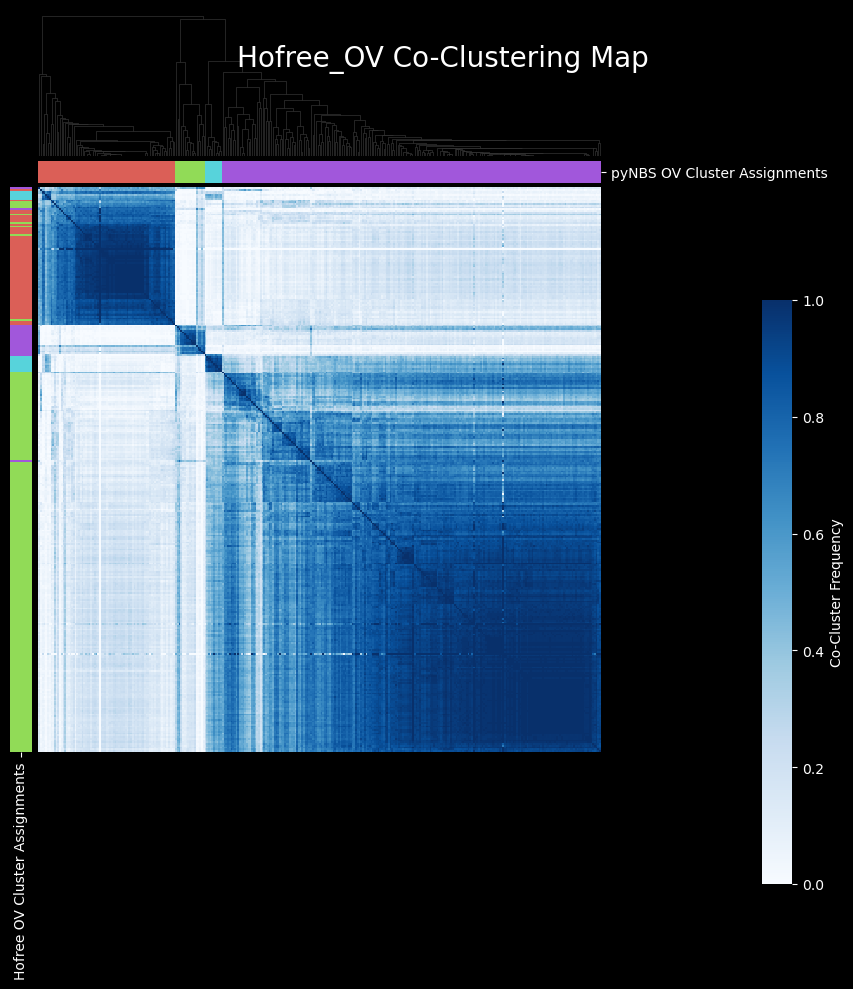

In [23]:
Image(filename = save_args['outdir']+save_args['job_name']+'_cc_map.png', width=600, height=600)

# Survival analysis
To determine if the patient clusters are prognostically relevant, we perform a standard survival analysis using a multi-class logrank test to evaluate the significance of survival separation between patient clusters. This data is plotted using a Kaplan-Meier plot using the [`cluster_KMplot()`](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_plotting.cluster_KMplot) in the [`pyNBS_plotting`](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_plotting) module. 


In order to plot the survival differences between clusters, we will need to load survival data for each patient. This data was extracted from TCGA clinical data. The survival data is given in a 5-column delimited table with the specific headings described below (the columns must be in the same order as shown below). The following is an example of a few lines of a survival table:  

||vital_status|days_to_death|days_to_last_followup|overall_survival|
|-|-|-|-|-|
|TCGA-2E-A9G8|0|0|1065|1065|
|TCGA-A5-A0GI|0|0|1750|1750|
|TCGA-A5-A0GM|0|0|1448|1448|
|TCGA-A5-A1OK|0|0|244|244|
|TCGA-A5-AB3J|0|0|251|251|

Additional details on the survival data file format is also describe on our Github wiki at: 
https://github.com/huangger/pyNBS/wiki/Patient-Survival-Data-File-Format

Note: The default setting for pyNBS is that no survival curves are drawn because the survival data is not a required parameter. The path to valid survival data must be explicitly defined.

Multi-Class Log-Rank P: 0.00978666429184107
Kaplan Meier Plot constructed


/Users/vlad/Documents/Code/York/pyNBS_py3/pyNBS/pyNBS_plotting.py:107: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


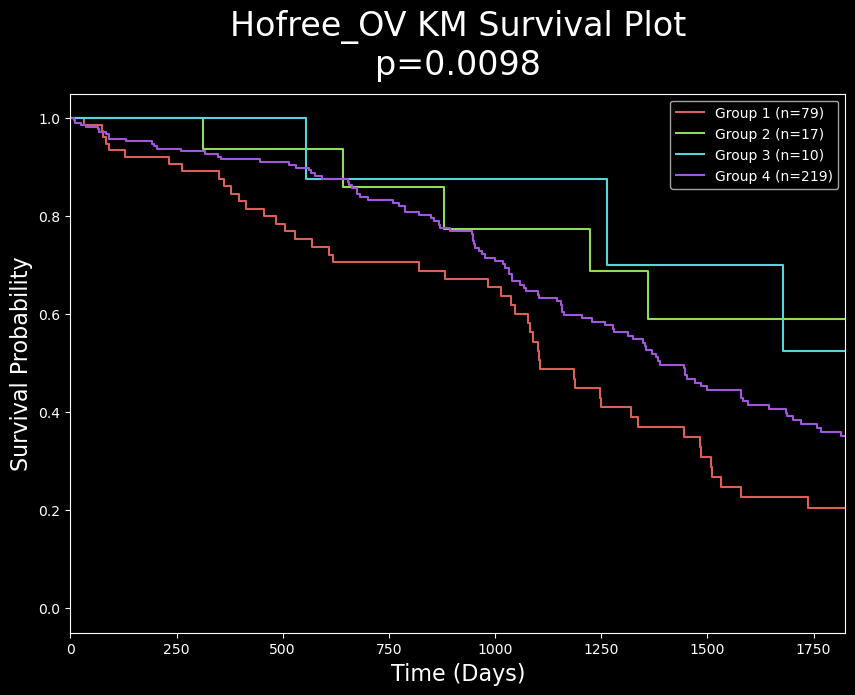

In [24]:
# Load survival Data
surv_data = './Example_Data/Clinical_Files/OV.clin.merged.Hofree.txt'

# Plot KM Plot for patient clusters
plot.cluster_KMplot(NBS_cluster_assign, surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)

# pyNBS Result comparison to Hofree et al 2013
We also compare the pyNBS clustering results against the original Hofree 2013 cluster assignments of the same patient data using two scores:  
[adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) and [adjusted mutual information score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html).

In [25]:
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score

In [26]:
adj_rand_index = adjusted_rand_score(Hofree_OV_clust, pyNBS_OV_clust)
adj_mutual_info_score = adjusted_mutual_info_score(Hofree_OV_clust, pyNBS_OV_clust)
print ('Adjusted Rand Index is: ' + str(adj_rand_index))
print ('Adjusted Mutual Info Score is: ' + str(adj_mutual_info_score))

Adjusted Rand Index is: 0.8710635206359034
Adjusted Mutual Info Score is: 0.7749426140254227


### Chi-Squared Association Test

We report in the Application Note the ability of pyNBS to recover the Hofree et al results by the significance of a multi-class Chi-squared statistic. We calculate that here:

In [27]:
import scipy.stats as stats

In [29]:
# Construct contingency table for cluster assignments
intersect_OV_pats = list(cluster_align.index)
NBS_OV_cont_table_array = []
for i in range(1,clusters+1):    
    Hofree_cluster = set(Hofree_OV_clust.loc[intersect_OV_pats][Hofree_OV_clust.loc[intersect_OV_pats]==i].index)
    Hofree_pyNBS_cluster_intersect = []
    for j in range(1,clusters+1):
        pyNBS_cluster = set(pyNBS_OV_clust.loc[intersect_OV_pats][pyNBS_OV_clust.loc[intersect_OV_pats]==j].index)
        Hofree_pyNBS_cluster_intersect.append(len(Hofree_cluster.intersection(pyNBS_cluster)))
    NBS_OV_cont_table_array.append(Hofree_pyNBS_cluster_intersect)
    
# Display contingency table
pd.DataFrame(NBS_OV_cont_table_array, 
             index=['Hofree Cluster '+repr(i) for i in range(1, clusters+1)],
             columns=['pyNBS Cluster '+repr(i) for i in range(1, clusters+1)])

,pyNBS Cluster 1,pyNBS Cluster 2,pyNBS Cluster 3,pyNBS Cluster 4
Hofree Cluster 1,63,0,0,0
Hofree Cluster 2,9,0,0,218
Hofree Cluster 3,5,0,9,0
Hofree Cluster 4,2,17,1,1


In [30]:
# Calculate p-value and chi-squared statistic:
chi_sq_test = stats.chi2_contingency(NBS_OV_cont_table_array, correction=False)
print ('Chi-Squared Statistic:', chi_sq_test[0])
print ('Chi-Squared P-Value:', chi_sq_test[1])

Chi-Squared Statistic: 707.213672680705
Chi-Squared P-Value: 1.945306230400468e-146
